<a href="https://colab.research.google.com/github/jdtoscano94/Learning-PINNs-in-Pytorch/blob/main/1_Approximate_a_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
 ! pip install pyDOE

In [2]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cuda


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print('da')
    print(torch.cuda.get_device_name()) 

cuda


Utils


In [4]:
def plot3D(x,t,y):
  X,T = torch.meshgrid(x,t)
  F_y=y
  fig,ax= plt.subplots(1,1)
  cp= ax.contourf(T,X,F_y,20,cmap ='rainbow')
  fig.colorbar(cp)
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_title('F(x,t)')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(),F_y.numpy(), cmap='rainbow')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_title('f(x,t)')
  plt.show()

def plot3D_matrix(X,T,Y):

  F_y=Y
  fig,ax= plt.subplots(1,1)
  cp= ax.contourf(T,X,F_y,20,cmap ='rainbow')
  fig.colorbar(cp)
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_title('F(x,t)')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(),F_y.numpy(), cmap='rainbow')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_title('f(x,t)')
  plt.show()

# Tunning Parameters

In [5]:
steps=20000
lr=1e-3

# Functions

In [6]:
def f_real(x,t):
  return torch.exp(-t)*(torch.sin(np.pi*x))



/home/gitesh/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


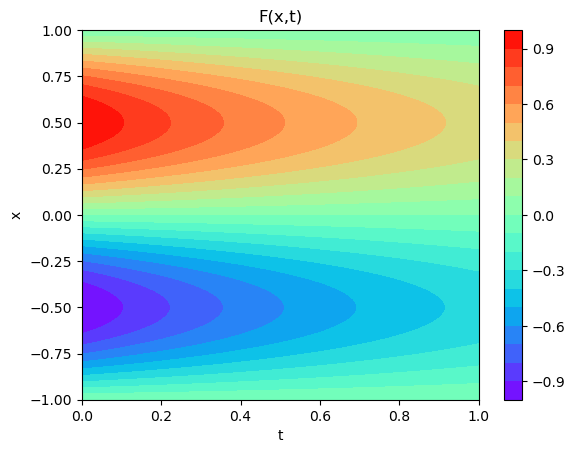

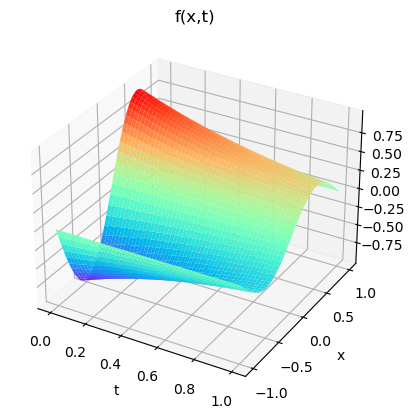

torch.Size([200, 1]) torch.Size([200, 100]) torch.Size([100, 1])
torch.Size([200, 100]) torch.Size([200, 100])


In [7]:
x = torch.linspace(-1,1,200).view(-1,1)
t = torch .linspace(0,1,100).view(-1,1)

X,T = torch.meshgrid(x.squeeze(1),t.squeeze(1))
y_real = f_real(X,T)
plot3D_matrix(X,T,y_real)
print(x.shape,y_real.shape,t.shape)
print(X.shape,T.shape)


Testing data

In [8]:
x_test =  torch.hstack((X.transpose(1,0).flatten()[:,None], T.transpose(1,0).flatten()[:,None]))

y_test = y_real.transpose(1,0).flatten()[:,None]

lb= x_test[0]
ub = x_test[-1]

print(x_test.shape, y_test.shape)
print(lb.numpy(),ub.numpy())

torch.Size([20000, 2]) torch.Size([20000, 1])
[-1.  0.] [1. 1.]


training data

In [9]:
ini_x = torch.hstack((X[:,0][:,None], T[:,0][:,None]))
ini_y = torch.sin(np.pi*ini_x[:,0]).unsqueeze(1)
print(ini_y.shape)

bound_top_x = torch.hstack((X[-1,:][:,None], T[-1,:][:,None]))
bound_top_y = torch.zeros(bound_top_x.shape[0],1)

bound_bot_x = torch.hstack((X[0,:][:,None], T[0,:][:,None]))
bound_bot_y = torch.zeros(bound_bot_x.shape[0],1)

X_train = torch.vstack([ini_x,bound_top_x,bound_bot_x])
Y_train = torch.vstack([ini_y,bound_top_y,bound_bot_y])

print(X_train.shape)
Nu = 100
idx = np.random.choice(X_train.shape[0], Nu, replace = False)

X_train_Nu = X_train[idx,:]
Y_train_Nu = Y_train[idx,:]


#Collocation points

Nf = 10000
X_train_Nf= lb + (ub-lb)*lhs(2,Nf)
print(X_train_Nf.shape)

X_train_Nf = torch.vstack((X_train_Nf, X_train_Nu))

torch.Size([200, 1])
torch.Size([400, 2])
torch.Size([10000, 2])


In [10]:
print("Original shapes for X and Y:",X.shape,y_real.shape)
print("Boundary shapes for the edges:",ini_x.shape,bound_bot_x.shape,bound_top_x.shape)
print("Available training data:",X_train.shape,Y_train.shape)
print("Final training data:",X_train_Nu.shape,Y_train_Nu.shape)
print("Total collocation points:",X_train_Nf.shape)

Original shapes for X and Y: torch.Size([200, 100]) torch.Size([200, 100])
Boundary shapes for the edges: torch.Size([200, 2]) torch.Size([100, 2]) torch.Size([100, 2])
Available training data: torch.Size([400, 2]) torch.Size([400, 1])
Final training data: torch.Size([100, 2]) torch.Size([100, 1])
Total collocation points: torch.Size([10100, 2])


In [11]:
torch.manual_seed(123)

X_train_Nu = X_train_Nu.float().to(device)
Y_train_Nu = Y_train_Nu.float().to(device)
X_train_Nf = X_train_Nf.float().to(device)
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)

X_test=x_test.float().to(device) # the input dataset (complete)
Y_test=y_test.float().to(device) # the real solution 



In [12]:
class FCN(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0
        
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
        
        #last layer we dont want activation but actual value
        a = self.linears[-1](a)
        
        return a

    def loss_BC(self,x_BC, y_BC):
        loss_BC = self.loss_function(self.forward(x_BC), y_BC)
        return loss_BC

    def loss_PDE(self,x_PDE):
      g = x_PDE.clone()
      g.requires_grad = True
      f = self.forward(g)
      f_x_t = autograd.grad(f,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
      f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device),create_graph=True)[0]
      # print(f_x_t)
      f_t = f_x_t[:,[1]]
      
      f_xx = f_xx_tt[:,[0]]
      f = f_t - f_xx + torch.exp(-g[:,1:])*(torch.sin(np.pi * g[:,0:1]) - np.pi**2 *torch.sin(np.pi*g[:,0:1]))
      return self.loss_function(f,f_hat)

    def loss(self,x_BC, y_BC,x_PDE):
      loss_bc = self.loss_BC(x_BC, y_BC)
      loss_PDE = self.loss_PDE(x_PDE)

      loss_val=loss_bc + loss_PDE
      return loss_val

    def closure(self):
      optimizer.zero_grad()  
      loss = self.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
      loss.backward()      
      self.iter += 1
      if self.iter % 100 == 0:
        loss2=self.lossBC(X_test,Y_test)
        print("Training Error:",loss.detach().cpu().numpy(),"---Testing Error:",loss2.detach().cpu().numpy())
      return loss  

    # def closure(self):
        
    #     optimizer.zero_grad()
        
    #     loss = self.lossNN(x_train, y_train)
        
    #     loss.backward()
                
    #     self.iter += 1
        
    #     if self.iter % 100 == 0:
        
    #         print(loss)

    #     return loss   

TRAining

In [24]:
layers = np.array([2,64,32,1])
lr = 1e-3
#Create Model
PINN = FCN(layers)
PINN.to(device)
print(PINN)
params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [25]:
steps = 20000
for i in range(steps):
    loss =PINN.loss(X_train_Nu, Y_train_Nu, X_train_Nf)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      with torch.no_grad():
        test_loss = PINN.loss_BC(X_test, Y_test)
      print("training", loss, "testing", test_loss)

training tensor(17.6665, device='cuda:0', grad_fn=<AddBackward0>) testing tensor(0.1945, device='cuda:0')
training tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>) testing tensor(0.0367, device='cuda:0')
training tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>) testing tensor(0.0367, device='cuda:0')
training tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>) testing tensor(0.0364, device='cuda:0')
training tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>) testing tensor(0.0360, device='cuda:0')
training tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>) testing tensor(0.0363, device='cuda:0')
training tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>) testing tensor(0.0362, device='cuda:0')
training tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>) testing tensor(0.0361, device='cuda:0')
training tensor(8.3415e-05, device='cuda:0', grad_fn=<AddBackward0>) testing tensor(0.0362, device='cuda:0')
training tensor(7.2668e-05, device='cuda:0', grad_

Results 


In [21]:
y_res = PINN(X_test)
x_res = X_test[:,0]
t_res = X_test[:,1]

x_res_mat = x_res.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
t_res_mat = t_res.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
y_res_mat = y_res.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
y_true = Y_test.reshape(shape=[100,200]).transpose(1,0).detach().cpu()

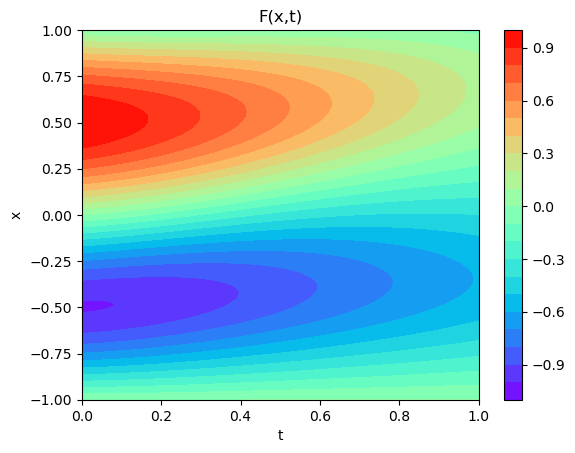

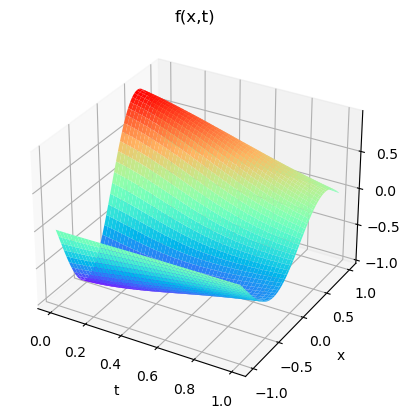

In [22]:
plot3D_matrix(x_res_mat,t_res_mat,y_res_mat)

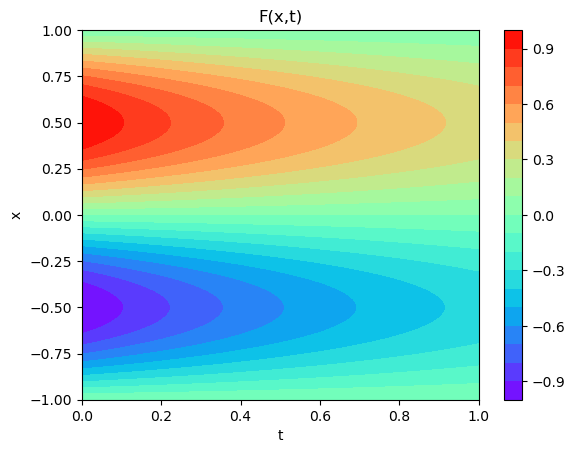

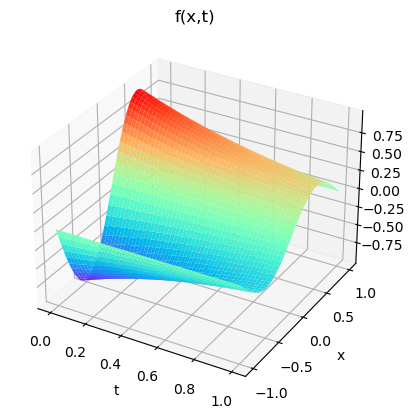

In [20]:
plot3D_matrix(X,T,y_real)

In [ ]:
layers = np.array([2,64,32,1])
lr = 1e-3
#Create Model
PINN = FCN(layers)
PINN.to(device)
print(PINN)
params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
steps = 20000
for i in range(steps):
    loss =PINN.loss(X_train_Nu, Y_train_Nu, X_train_Nf)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      with torch.no_grad():
        test_loss = PINN.loss_BC(X_test, Y_test)
      print("training", loss, "testing", test_loss)

training tensor(17.6665, device='cuda:0', grad_fn=<AddBackward0>) testing tensor(0.1945, device='cuda:0')
training tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>) testing tensor(0.0367, device='cuda:0')
training tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>) testing tensor(0.0367, device='cuda:0')


In [ ]:
y_res = PINN(X_test)
x_res = X_test[:,0]
t_res = X_test[:,1]

x_res_mat = x_res.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
t_res_mat = t_res.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
y_res_mat = y_res.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
y_true = Y_test.reshape(shape=[100,200]).transpose(1,0).detach().cpu()

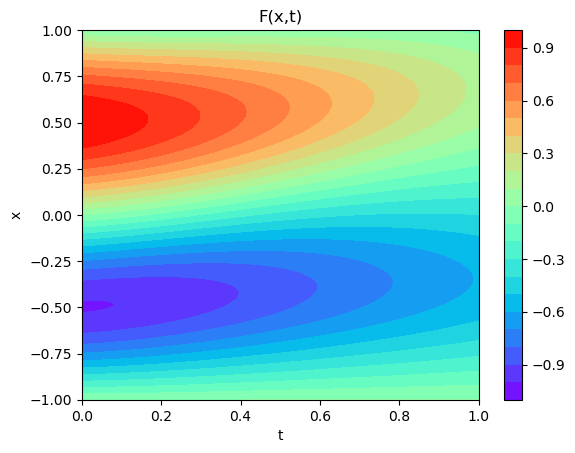

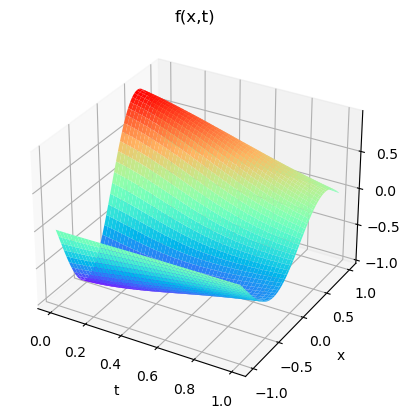

In [ ]:
plot3D_matrix(x_res_mat,t_res_mat,y_res_mat)

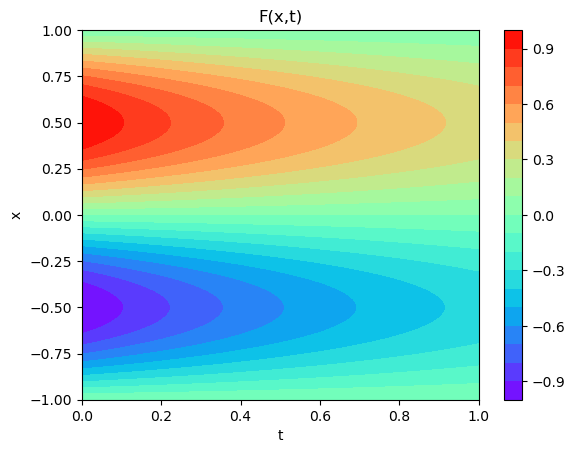

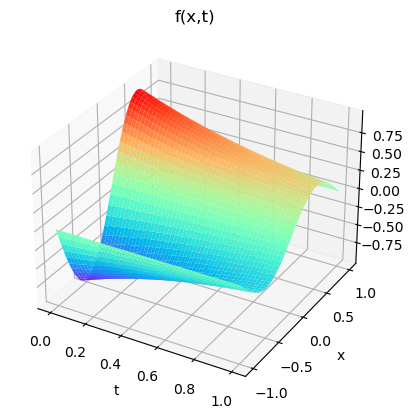

In [ ]:
plot3D_matrix(X,T,y_real)

In [ ]:
layers = np.array([2,64,32,1])
lr = 1e-3
#Create Model
PINN = FCN(layers)
PINN.to(device)
print(PINN)
params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
steps = 20000
for i in range(steps):
    loss =PINN.loss(X_train_Nu, Y_train_Nu, X_train_Nf)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      with torch.no_grad():
        test_loss = PINN.loss_BC(X_test, Y_test)
      print("training", loss, "testing", test_loss)

training tensor(17.6665, device='cuda:0', grad_fn=<AddBackward0>) testing tensor(0.1945, device='cuda:0')
training tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>) testing tensor(0.0367, device='cuda:0')
training tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>) testing tensor(0.0367, device='cuda:0')


In [ ]:
y_res = PINN(X_test)
x_res = X_test[:,0]
t_res = X_test[:,1]

x_res_mat = x_res.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
t_res_mat = t_res.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
y_res_mat = y_res.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
y_true = Y_test.reshape(shape=[100,200]).transpose(1,0).detach().cpu()

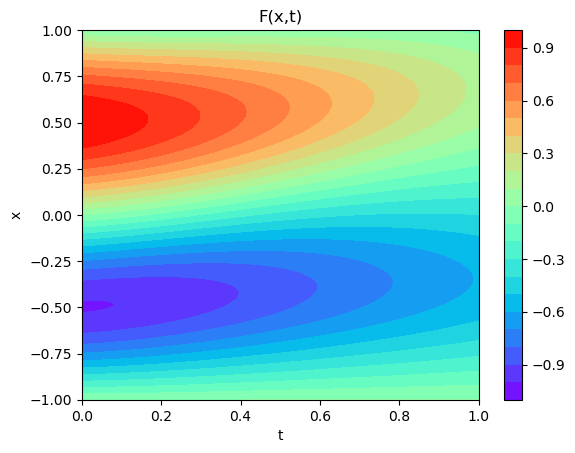

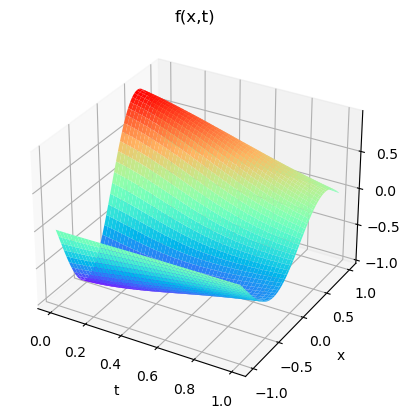

In [ ]:
plot3D_matrix(x_res_mat,t_res_mat,y_res_mat)

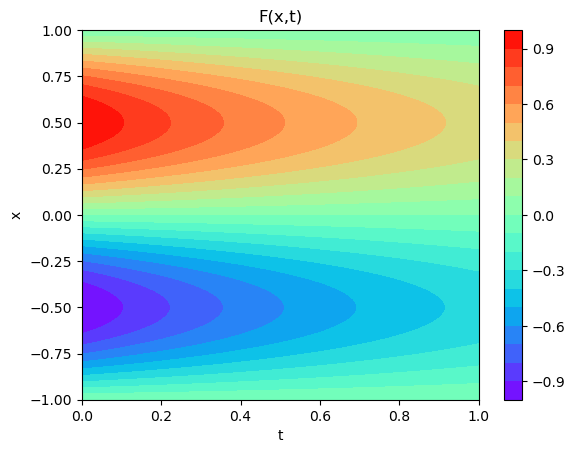

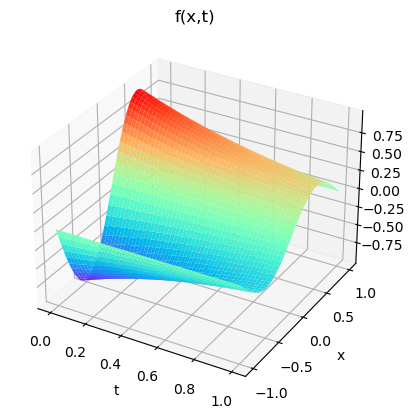

In [ ]:
plot3D_matrix(X,T,y_real)